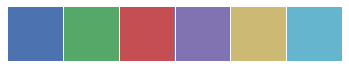

In [2]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import six

import edward as ed
import tensorflow as tf

from tensorflow.contrib.distributions.python.ops import bijectors as bijector

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture, Mixture,
    NormalWithSoftplusScale)


import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns

# let edward communicate with tensorflow
sess = ed.get_session()

sns.palplot(sns.color_palette())

ed.set_seed(42)

In [3]:
true_pi = np.array([0.2, 0.8])
true_mus = [[1., 1.], [-1., -1.]]
true_stds = [[0.1, 0.1], [0.1, 0.1]]


def build_toy_dataset(N, pi=true_pi, mus=true_mus, stds=true_stds):
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, true_pi))
    x[n, :] = np.random.multivariate_normal(true_mus[k], np.diag(true_stds[k]))
  return x

In [4]:
N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data


x_train = build_toy_dataset(N)
transformedx_train = 5.0*x_train + 3.0

In [ ]:
# Mixture model

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)

cat = Categorical(probs=pi, sample_shape=N)
components = [
    MultivariateNormalDiag(mu[k], sigmasq[k], sample_shape=N)
    for k in range(K)]

x = Mixture(cat=cat, components=components, sample_shape=N)

transformedx = ed.models.TransformedDistribution(
  distribution=x,
  bijector=tf.contrib.distributions.bijectors.Affine(
    shift=3.,
    scale_identity_multiplier=5.,
    event_ndims=0),
  name="transformedx", sample_shape = N)

/Users/maudelachaine/project_env/project-2.7/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


[[-0.12200748  0.31956738]
 [ 0.96000874 -1.5143105 ]]
{'loss': 3452.5093, 't': 1}
[[-0.13026962  0.30995962]
 [ 0.95066196 -1.505095  ]]
{'loss': 3248.552, 't': 101}
[[-0.13813761  0.30040285]
 [ 0.94085497 -1.4961698 ]]
{'loss': 3244.105, 't': 201}
[[-0.1461622   0.29130137]
 [ 0.93155336 -1.4868786 ]]
{'loss': 3545.5994, 't': 301}
[[-0.15360568  0.28204888]
 [ 0.9225227  -1.4781362 ]]
{'loss': 3299.0728, 't': 401}
[[-0.16096026  0.2730115 ]
 [ 0.91324383 -1.4692754 ]]
{'loss': 3384.4512, 't': 501}
[[-0.16899002  0.2637441 ]
 [ 0.903914   -1.4607921 ]]
{'loss': 3081.2083, 't': 601}
[[-0.17619306  0.25451562]
 [ 0.8950716  -1.4530656 ]]
{'loss': 3372.2397, 't': 701}
[[-0.1833559   0.24581614]
 [ 0.8863945  -1.4443766 ]]
{'loss': 3005.3184, 't': 801}
[[-0.19046628  0.23695609]
 [ 0.8777645  -1.4362093 ]]
{'loss': 3141.8906, 't': 901}


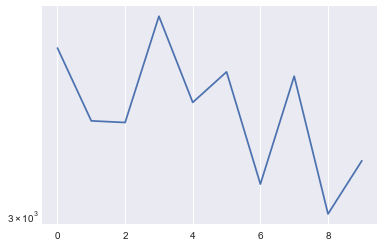

In [ ]:
# KLqp inference
qmu = Normal(loc=tf.Variable(tf.random_normal([K,D])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([K,D]))))
qsigmasq = ed.models.TransformedDistribution(distribution = NormalWithSoftplusScale(tf.Variable(tf.zeros([K,D])), tf.Variable(tf.zeros([K,D]))), bijector=bijector.Exp())

inference = ed.KLqp({mu:qmu, sigmasq:qsigmasq}, data={transformedx: transformedx_train})

n_iter = 1000
n_print = 500
n_samples = 100
optimizer = tf.train.AdamOptimizer(1e-4)

inference.initialize(n_iter=n_iter, n_print=n_print, n_samples=n_samples,optimizer =optimizer)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(qmu.loc.eval())
        print(info_dict)
        learning_curve.append(info_dict['loss'])

plt.semilogy(learning_curve)
plt.show()

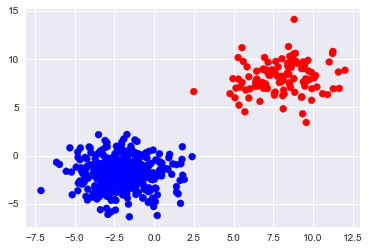

In [8]:
# Assignment clusters

M = 100
mu_sample = qmu.sample(M)
sigmasq_sample = qsigmasq.sample(M)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, M, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)


clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(transformedx_train[:, 0], transformedx_train[:, 1], c=clusters, cmap=cm.bwr)

In [2]:
postmu = qmu.loc.eval()
plt.scatter(5.0*postmu[:, 0]+3.0, 5.0*postmu[:, 1]+3.0, marker = 'x')

plt.show()

NameError: name 'qmu' is not defined

In [ ]:
sns.pairplot(haberman, hue='survived_more_than_5_years', size = 4)

In [ ]:
plt.plot(v_params.elbo_vals[10000:])
sns.despine()

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred))